## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


User-User - это рекомендация товаров на основании схожести пользователей (напр. я купила товары, которые также купил другой клиент, т.е. предположительно у нас схожи вкусы - можно мне рекомендовать другие товары из его покупок, с большой долей вероятности они мне понравятся тоже)

Item-Item - рекомендации на осонове похожести товаров (рекомендации типа "С этим товаром часто покупают", т.е формируется множество объектов похожих на товар (с таким же рейтингом или, например, фильмы с такими же актерами) или часто участвующих с ним в связке (Совстречаемости) и рекомендуюся ближайшие "соседи")

Схожесть в базе для анализа таблица типа user-item из которой для анализа беруться разные данные в зависимости от метода рекомендации. Каждый из методов рекомендаций имеет свои несдостатки: для user-based рекомендаций - это растущее количество пользователей, а также рекомендации для холодных пользователей, которые еще не оставили о себе данныых для сравнения, для item-based это трудоемкость и субъективность оценок пользователей (кто-то всем ставит 2, а кто-то завышает из-за чего сложно говорить о реально схожести товаров по какаим-то характеристикам между собой). 

Функцию item_item_rec(interaction_matrix) можно использовать для user_user_rec, если транспорнировать матрицу так, чтобы по строкам получись юзеры (User), а по столбцам - товары (Item).

В Item-Item мы используем KNN (метод ближайших соседей), исползуем полностью всю матрицу, учитываем только кейсы реального взаимодействия. В ALS мы используем разложение матрицы на матрицу факторов юзеров и матрицу факторов товаров и исследуем взаимодействие матрицы ембедингов юзеров и товаров, даже если пользователь не имел взаимодействия с товаром, то эта характеристика тоже влияет на результат.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


1. товары из той же группы, что были купленны ранее (канцелярия, аксессуары, принадлежности для авто)
2. рекомендовать какие-то новые товары (новинки по дате заведения в матрицу товаров), похожие с тем, что покупал ранее или из той же группы
3. если есть данные о пользователе, то учитывать их (дата рождения, количество детей)

Но это кажется, что-то не то... как вес можно учитывать частоту покупок товара пользователем и дату последней покупки (например, если купил один раз два года назад, то врядли купит еще, а если покупает с какой-то регулярностью, то скорее всего купит скоро). Можно ввести критерий оборачиваемости товара - как часто надо покупать следующий аналогичный, на какой период пользования расчитан товар, и предлагать снова, когда предполагаемый период пользования заканчивается. 

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


В анализе участвует только пользователь и товар, нет возможности сделать многофакторный анализ и подключить внешние фичи в качестве параметров, в качестве рузультата получаем не вероятность оценку.
Для разложения User-Item матрицы на матрицы эмбедингов юзеров и товаров необходимо, чтобы каждый пользователь сделал хотя бы одну покупку или чтобы каждый товар купили хотя бы один раз.

## Практическая часть


In [1]:
!pip install implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys


In [3]:
data = pd.read_csv('C:/Users/sklod/OneDrive/Рабочий стол/STUDY/!Теория/Q4.Рекомендательные системы/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

C:\Users\sklod\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [6]:
def precision(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(recommended_list)
    
def precision_at_k(recommended_list, 
                    bought_list, 
                    k=5):
    return precision(recommended_list[:k], bought_list) # K - кол-во билжайших соседей

In [7]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],
                                    recalculate_user=True)]
    return res

In [8]:
def ALS_tester(user_item_matrix, name_of_column):
    model = AlternatingLeastSquares(factors=100, 
                                    regularization=0.001,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    use_gpu=False) 

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

    result[name_of_column] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [9]:
def test_matrix_weight (name_of_column, name_of_func, fill_value=0):
    global user_item_matrix
    global sparse_user_item
    global id_to_itemid
    global id_to_userid
    global itemid_to_id
    global userid_to_id
    
    user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', 
                                  aggfunc=name_of_func, 
                                  fill_value=fill_value
                                 )
    

    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()# переведем в формат saprse matrix
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values
    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))
    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))
    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))    
    
    ALS_tester(user_item_matrix, name_of_column)
      

In [10]:
test_matrix_weight('count', 'count' )

In [11]:
test_matrix_weight('max','max')

In [12]:
test_matrix_weight('mean','mean')

In [13]:
test_matrix_weight('nunique','nunique')

In [14]:
df = pd.DataFrame(columns=['aggfunc', 'presision_at_k'])
i = 0
for column in result.columns[2:]:
    presision = round(result.apply(lambda row: precision_at_k(row[column], row['actual']), axis=1).mean(), 5)
    df.loc[i] = [column, presision]
    i += 1

df.sort_values(by='presision_at_k', ascending=False)

,aggfunc,presision_at_k
3,nunique,0.20392
2,mean,0.19109
1,max,0.18580
0,count,0.18080


Cамый высокий результат даёт "nunique", потому что nunique косвенно пересекается с популярностью товара.

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [16]:
# лучшая матрица из первого задания с весом 'nunique'

user_item_matrix = pd.pivot_table(data_train, 
                              index='user_id', columns='item_id', 
                              values='quantity', 
                              aggfunc='nunique', # 'nunique' показал лучший результат в первом задании
                              fill_value=0
                             )
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
sparse_user_item = csr_matrix(user_item_matrix).tocsr()# переведем в формат saprse matrix
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values
matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))
id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))
itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [17]:
# проверяю на валидационном сете
valid = data_train.groupby('user_id')['item_id'].unique().reset_index()
valid.columns=['user_id', 'actual']
valid.head(2)

,user_id,actual
0,1,"[999999, 840361, 845307, 852014, 856942, 91267..."
1,2,"[854852, 930118, 1077555, 1098066, 999999, 556..."


In [19]:
# в колабе с Оксаной Дегтярёвой

rers_k_test=dict()
rers_k_valid = dict()
n=1

for factors in np.linspace(20,250,5):
    for regularization in np.geomspace(0.0001,0.1,5):

        
        model = AlternatingLeastSquares(factors=int(factors), 
                                        regularization=regularization,
                                        iterations=15, 
                                        calculate_training_loss=True, 
                                        num_threads=8)

        model.fit(csr_matrix(user_item_matrix).T.tocsr(),show_progress=False)
        
        # train
        result[f'fs={factors}_rg={regularization}'] = \
                        result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

        k = result.apply(lambda row: precision_at_k(row[f'fs={factors}_rg={regularization}'], \
                                                            row['actual']), axis=1).mean()
        # test
        valid[f'fs={factors}_rg={regularization}'] = \
                        valid['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

        k_valid = valid.apply(lambda row: precision_at_k(row[f'fs={factors}_rg={regularization}'], \
                                                            row['actual']), axis=1).mean()
        
        rers_k_test[n] = [factors, regularization, k, k_valid]
        n+=1

выполнялось мегадолго....

выведем в виде таблицы результаты для разных гиперпараметров

In [25]:
summary = pd.DataFrame.from_dict(rers_k_test,orient='index',columns=['factors', 'regularization',"train_precision_at_k", "valid_precision_at_k"])
summary[['factors', 'regularization',"train_precision_at_k", "valid_precision_at_k"]].sort_values(by='valid_precision_at_k', ascending=False).head(10)

,factors,regularization,train_precision_at_k,valid_precision_at_k
21,250.0,0.000100,0.162586,0.967747
23,250.0,0.003162,0.161900,0.967427
22,250.0,0.000562,0.157101,0.967187
24,250.0,0.017783,0.159941,0.966467
25,250.0,0.100000,0.163957,0.966467
16,192.5,0.000100,0.172772,0.955182
18,192.5,0.003162,0.172086,0.954942
19,192.5,0.017783,0.177669,0.954542
17,192.5,0.000562,0.170813,0.954302
20,192.5,0.100000,0.174143,0.952381


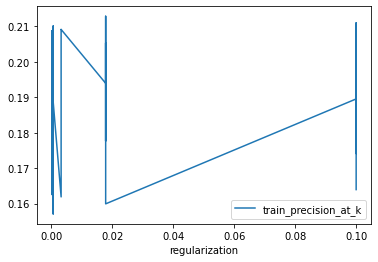

In [26]:
summary.sort_values(by='regularization').plot(x ='regularization', y='train_precision_at_k', kind = 'line')
plt.show()

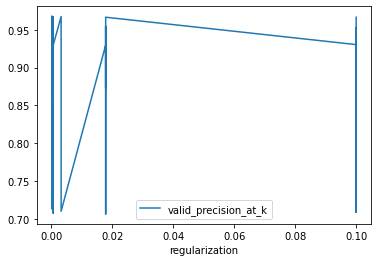

In [28]:
summary.sort_values(by='regularization').plot(x ='regularization', y='valid_precision_at_k', kind = 'line')
plt.show()

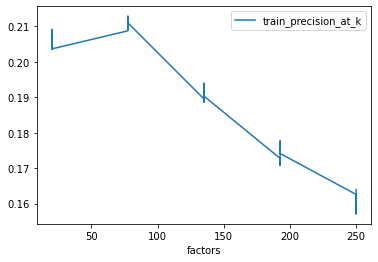

In [29]:
summary.sort_values(by='factors').plot(x ='factors', y='train_precision_at_k', kind = 'line')
plt.show()

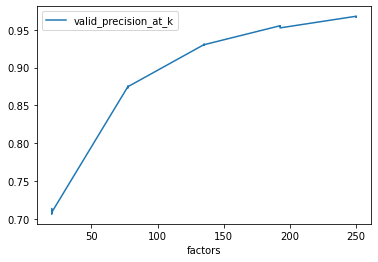

In [30]:
summary.sort_values(by='factors').plot(x ='factors', y='valid_precision_at_k', kind = 'line')
plt.show()

Регуляризация непредсказуемо влияет на качество, в то время как у факторов можно видеть оптимальные участки в районе 80

In [31]:
!pip install hyperopt

# Use hyperopt!

я изучила несколько примеров применения, посмотрела как работает hyperopt на примере датасета с ирисами. Очень удобная штука для оптимизации подбора гиперпараметров! Я не разобралась как прикрутить его к нашей задаче((

In [32]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
 
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
 
# Для теста возьмем классический сет "ирисы Фишера"
# Разумеется вместо X и y Вам следует взять свои фичи и таргет
iris = datasets.load_iris()
X = iris.data
y = iris.target
 
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X, y, cv=3).mean()
    print(current_score, params)
    return -current_score 
 
simple_space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
}
 
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

[14:44:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/10 [00:01<?, ?trial/s, best loss=?]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/10 [00:02<?, ?trial/s, best loss=?]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.96                                                                                                                   
{'eta': 0.5, 'max_depth': 11, 'n_estimators': 200}                                                                     
[14:44:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|██████▏                                                       | 1/10 [00:03<00:24,  2.75s/trial, best loss: -0.96]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:44:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|██████▏                                                       | 1/10 [00:06<00:24,  2.75s/trial, best loss: -0.96]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:44:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|██████▏                                                       | 1/10 [00:09<00:24,  2.75s/trial, best loss: -0.96]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.96                                                                                                                   
{'eta': 0.17500000000000002, 'max_depth': 10, 'n_estimators': 868}                                                     
[14:44:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 20%|████████████▍                                                 | 2/10 [00:11<00:36,  4.53s/trial, best loss: -0.96]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:44:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 20%|████████████▍                                                 | 2/10 [00:13<00:36,  4.53s/trial, best loss: -0.96]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 20%|████████████▍                                                 | 2/10 [00:14<00:36,  4.53s/trial, best loss: -0.96]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.9666666666666667                                                                                                     
{'eta': 0.35000000000000003, 'max_depth': 7, 'n_estimators': 899}                                                      
[14:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 30%|██████████████▍                                 | 3/10 [00:16<00:31,  4.53s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 30%|██████████████▍                                 | 3/10 [00:18<00:31,  4.53s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 30%|██████████████▍                                 | 3/10 [00:20<00:31,  4.53s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.9666666666666667                                                                                                     
{'eta': 0.375, 'max_depth': 10, 'n_estimators': 642}                                                                   
[14:45:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 40%|███████████████████▏                            | 4/10 [00:21<00:29,  4.88s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 40%|███████████████████▏                            | 4/10 [00:23<00:29,  4.88s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 40%|███████████████████▏                            | 4/10 [00:24<00:29,  4.88s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.96                                                                                                                   
{'eta': 0.1, 'max_depth': 2, 'n_estimators': 749}                                                                      
[14:45:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 50%|████████████████████████                        | 5/10 [00:25<00:22,  4.53s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 50%|████████████████████████                        | 5/10 [00:26<00:22,  4.53s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 50%|████████████████████████                        | 5/10 [00:27<00:22,  4.53s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.96                                                                                                                   
{'eta': 0.35000000000000003, 'max_depth': 6, 'n_estimators': 424}                                                      
[14:45:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 60%|████████████████████████████▊                   | 6/10 [00:27<00:15,  3.88s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 60%|████████████████████████████▊                   | 6/10 [00:29<00:15,  3.88s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 60%|████████████████████████████▊                   | 6/10 [00:30<00:15,  3.88s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.96                                                                                                                   
{'eta': 0.225, 'max_depth': 5, 'n_estimators': 800}                                                                    
[14:45:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 70%|█████████████████████████████████▌              | 7/10 [00:31<00:11,  3.86s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 70%|█████████████████████████████████▌              | 7/10 [00:32<00:11,  3.86s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 70%|█████████████████████████████████▌              | 7/10 [00:33<00:11,  3.86s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.9666666666666667                                                                                                     
{'eta': 0.47500000000000003, 'max_depth': 2, 'n_estimators': 699}                                                      
[14:45:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|██████████████████████████████████████▍         | 8/10 [00:35<00:07,  3.73s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|██████████████████████████████████████▍         | 8/10 [00:35<00:07,  3.73s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|██████████████████████████████████████▍         | 8/10 [00:36<00:07,  3.73s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.96                                                                                                                   
{'eta': 0.125, 'max_depth': 3, 'n_estimators': 406}                                                                    
[14:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 90%|███████████████████████████████████████████▏    | 9/10 [00:37<00:03,  3.27s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 90%|███████████████████████████████████████████▏    | 9/10 [00:38<00:03,  3.27s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 90%|███████████████████████████████████████████▏    | 9/10 [00:39<00:03,  3.27s/trial, best loss: -0.9666666666666667]

C:\Users\sklod\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.9666666666666667                                                                                                     
{'eta': 0.47500000000000003, 'max_depth': 8, 'n_estimators': 736}                                                      
100%|███████████████████████████████████████████████| 10/10 [00:40<00:00,  4.09s/trial, best loss: -0.9666666666666667]
best:
{'eta': 0.35000000000000003, 'max_depth': 6, 'n_estimators': 799}
